In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 為你寫詩 (pytorch)

支援python 版本: 3.5以上  
支援pytorch版本 : 1.2以上

詩詞歌賦是人類語言的精華，若要說什麼是語言能力最高的表現，那大概就是寫詩或是寫小說了。我們今天就要來嘗試讓機器也能夠生成詩詞歌賦，不過大家不要以為AI已經攻破了這個任務，相反的，人工智能在語言這條路上還有許多路得走，今天的實作機器所寫出來的與其說是創作，倒不如說是鸚鵡學舌來的貼切，機器的確能在大量語料中學習到語言的部分語義，搭配LSTM這個專門用於序列數據的算法，還是能夠產生一些蠻有趣的內容。

![Alt text](../images/tang-shi.jpg)

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'pytorch'

#!pip uninstall tridentx
#!pip install tridentx --upgrade
from trident import *

trident 0.6.0


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.


Pillow version:7.1.2.


Pytorch version:1.6.0+cu101.
Automatic Mixed Precision Support:True.


目前所有AI都是基於數據所驅動，因此我準備了6份語料，大家都可以套用在這次介紹的架構中進行訓練與推論，您也可以換成自己準備的語料文字檔(請注意需要有足夠數量才能夠訓練得夠好。)

item='jay' #周杰倫歌詞   
item='lingxi' #林夕歌詞   
item='poets54' #五言絕句   
item='poets74' #七言絕句   
item='poets58' #五言律詩  
item='poets78' #七言律詩  

## 為你寫歌詞

我們先從難度較低的開始著手，那就先用周董的歌吧。

In [3]:
item='jay' 
data_provider,original_corpus=load_text(item+'.txt',unit='char',mode='next_word',is_onehot=False,sequence_length=8,return_corpus=True)
t1,t2=data_provider.next()

total distinct chars: 2496
total distinct chars: 2496


在準備資料方面，我所設計的trident api中其實是透過TextSequenceDataset(負責儲存語料，以及將語料轉換為序列張量)以及TextSequenceDataProvider(作為提供數據的generator，負責供應數據的接口)這兩個物件來負責的。其中只需要透過比較簡單的load_text函數就可以設計好前述兩者的設定。loadtext的設定引數如下：

     filname (str)  :文字檔案來源的路徑
     data (str,list): 輸入語料
     label (str,list): 輸出語料
     unit (str)     :文字分割的基礎，有效值包括'char'(字)以及'word'(詞)，預設為'char'，目前中文尚不支援自動分詞
     mode (str)     :產生序列模式，有效值包括'next_word'(預測下一個字),skip_gram(前後文預測當前字元),cbow(當前字元預測前後文),
                     onehot(產生onehot向量),1to1_seq2seq (一隊依序列對序列)
     section_delimiter (str): 分區的分隔符號，為了避免撞號，因此要求需要使用連續兩個字元作為分隔符號，預測為'\n\n'
     sequence_start_at (str)：序列起始點選取方法，有效值包括'random'(隨機起始)，'slide'(活動窗口，意味著前後續序列可能重疊)
                     ,'follow_up'(接續，前後序列不重疊),'section_start'(以每個分區起點作為開始)
     is_onehot(bool): 是否為onehot
     encoding       :編碼，目前預設值為'utf-8-sig':
     sequence_length (int) :序列長度，預設值為64
     return_corpus(bool)   : 除了data provider外是否回傳原始語料



我們將data_provider提供的數據根據它自身的index2text方法還原，各位可以看到它除了語料本身之外，還額外插入了**<start\><end\><pad\>**等標籤，以作為文字分段的基礎參考。

In [4]:
for k in range(8):
    print(''.join([data_provider.index2text(i) for i in t1[k]]))
    print(''.join([data_provider.index2text(i) for i in t2[k]]))
    print('')
    
print(''.join(data_provider.vocabs))
print(data_provider.signature)
original_corpus=original_corpus.split('\n')

已經因為她甜得過
經因為她甜得過頭

這森林<end/><start/>而我的
森林<end/><start/>而我的眼

用微笑來帶過<end/><start/>
微笑來帶過<end/><start/>我

望他是真的比我還
他是真的比我還要

<end/><start/>大人們始終不
<start/>大人們始終不明

啦嗚<end/><start/>她養的黑
嗚<end/><start/>她養的黑貓

失在空中<end/><start/>記憶
在空中<end/><start/>記憶在

比較好一點<end/><start/>從
較好一點<end/><start/>從前

<start/><end/><unknown/><pad/>
 ()*+,-./12389:<>?[]`abcdefghijklmnoprstuvwxyz~·…☆　。〇《》〖〗ーㄇㄈㄌㄒㄙㄚㄟㄡ一丁七三上下不丑世丘丟並中丸丹主久之乎乒乓乖乘九也乾亂了予事二互五井亙些亞亡交亦享亭亮人什仁仇今介仍仔仕他仗付仙代令以仰件任份仿伊伏伐休伯伱伴伸似伽但佇佈位低住佔何佗佛作你佳佻使來供依侵便係促俊保俠信俯俺倉個們倒倔候借倦倫倭值假偉偎偏做停側偵偶偷偽傀傅傍傑傘備傲傳債傷傻傾像僵價儀儂儘儡優儲兀元兄充兆兇先光克免兒兜入內全兩八公六兮共兵其具典冉冊再冒冠冥冬冰冷准凋凝凡凱凶出刀分切刊列初判別利刪刮到制刷刺刻則削前剔剛剝剩剪副割創劃劇劍力功加助努劫勇勉勒動務勝勞勢勵勾包匆化北匙匠匹區十千升午半卑協南卜占卡卦印危即卷卸卻厚原厭厲去參又及友反叔取受叛叢口古句另叨叩只叫叭叮可台史右司吃吆合吉吊同名吐向君吝吞吟吠否吧含吭吳吵吸吹吻吼吾呀呆告呢呦周味呵呸呼命咆和咒咖咧咩咪咬咱咸咿哀品哈哉哎哥哦哩哪哭哮哼唇唐唯唰唱唸啃啊問啜啞啡啤啥啦啵喂善喇喉喊喔喘喚喜喝喧喪喬單喲嗅嗇嗎嗓嗚嗜嗦嗨嘆嘗嘛嘟嘯嘲嘴嘶嘿噙噠噢器噬噴噹嚇嚎嚴囂囉四回因囪困固圈國圍園圓圖團土在地圾坊坐坑坡坦垂垃型埃埋城培基堂堅堆堡堤堪報場堵塊塌塔塗塞填塵境墊墓墜增墟墨墮墳墻墾壁壇壓壕壘壞壤士壯壺夏夕外多夜夠夢大天太夫央失夾奇奈奉奏契奔套奪奮女奴奶她好如妖妙妝妥妳妹姆始姐姑姓委姥姻姿威娘娥婆婉婪媚媽嫋嫌嫣嫦嫩嬉嬌子孔字存孝孟季孤孩學它宇守安宋完宗官宙定宜客宣室宮害家容宿寂寄密寇寒寞察寥實寧寫寬寵寶寸寺封射將專尊尋對導小少尖尚尬就尷尺尼尾局屁居屈屋屌屍屏屑展屜層屬山岩岸

這次要實作的模型說是機器寫作，其實本質就是要機器基於已經知道的序列內容，預測下一個字。所以這種一個字一個字生成的模式，來構築出整個內容。這個也是深度學習語言模型中最基礎的Char-rnn。

![Alt text](../images/unlimited_monkey.jpg)

數學上有個「無限猴子理論」，說是給猴子一台打字機，只要給他無限的時間，總有一天可以打出莎士比亞全集。這樣講有點作弊，看來得是要等到猴子進化成人類後才寫得出來。期待猴子實在沒可能，那我們能否寄望神經網路呢?當然可以，我們將會示範如何透過lstm來讓機器能夠吟詩作賦。以下是這次的char-cnn的結構以及每個階段的張量尺寸。


![Alt text](../images/char_rnn.png)

模型結構就如同前圖所介紹的，我們預計將透過是將文字張量，先通過Embedding層抽取表徵，經過正規化之後直接導入至LSTM中，輸出的結果需要reshape在經過正規化以及全連接層，就可以輸出下一個字的預測值。

In [5]:
h_size=512
num_chars=len(data_provider.vocabs)


lstm1=Sequential(
    Embedding(embedding_dim=256,num_embeddings=num_chars,sparse=False,name='embed'),
    BatchNorm(in_sequence=True),
    LSTM(hidden_size=h_size,num_layers=2,stateful=False,batch_first=False,dropout_rate=0.2, name='lstm'),
    Reshape((h_size), name='reshape'),
    Dense(num_chars,use_bias=False,activation=None, name='fc'),
    SoftMax(-1,name='softmax')
    
)


我們將模型利用前面provider供應的數據作為範例資料來指定輸入與輸出，這樣就完成了模型結構設計。

In [6]:

lstm_jay=Model(inputs=t1,output=lstm1)

#if os.path.exists('Models/{0}.pth.tar'.format(item)):
#    lstm_jay.load_model('Models/{0}.pth.tar'.format(item))
lstm_jay.summary()

--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
embed                                    [-1, 8, 256]          [2496, 256]                    638976    327155456.0 
1                                        [-1, 8, 256]          [256]                [256]     512       196352.0    
lstm                                     torch.Size([1, 8, 512])                                 0         0.0         
reshape                                  [-1, 512]                                            0         0.0         
fc                                       [-1, 2496]            [2496, 512]                    1277952   2555903.0   
softmax                                  [-1, 2496]                                           0         0.0         
Total params: 1,917,440
Trainable params: 1,917,4

在這個文字生成模型，本質上就是一個分類問題，根據前面的狀態評估下一個字是什麼，所以我們直接使用常見的CrossEntropyLoss就可以，但是別忘了，由於是在序列內，因此目標值的形狀會是(批次,序列長)，這跟已經經過reshape層的輸出值不一樣，所以目標值也需要reshape一下。

In [7]:

def SequenceCrossEntropyLoss(output,target):
    target = target.reshape(-1)
    return CrossEntropyLoss(reduction='mean',axis=-1)(output,target)
    


def SequenceAccuracy(output,target):
    target=target.reshape(-1)
    return accuracy(output,target,axis=-1)


在最後模型的設定基本上是將剛才處理過的支持序列的CrossEntropyLoss以及Accuracy分別設定為損失函數與評估函數，為了避免LSTM梯度爆炸(理論上很少發生，但是以防萬一)，我加上了**梯度裁切(gradient clipping)**，然後我希望在模型訓練過程中可以即時看到預測的效果，因此我們需要讓訓練流程中定期調用剛剛寫好的write_something函數，以前是需要透過客製化Callbacks的方式來實現，**現在在trident中有更簡單的新方法就是使用模型中的trigger_when方法**。透過trigger_when的action(對應到輸入值為training_context的函數)以及設定基於什麼來觸發action的事件，舉例來說，我希望每500個批次就調用一次write_something函數，因此就可以設定在on_batch_end事件中觸發，不過每次觸發時，可以透過檢查training_context中目前的epoch以及batch數來判斷是否要繼續執行，這樣等於不需要重新撰寫callbacks類，就能做到同樣的效果。

In [8]:


def write_something(training_context):
    """

    :param training_context:
    :type training_context:
    """
    global data_provider, original_corpus
    epoch = training_context['current_epoch']
    batch = training_context['current_batch']
    num_batch = training_context['total_batch']
    if (epoch * num_batch + batch+1)% 500 == 0:
        model =copy.deepcopy( training_context['current_model'])
        # 模型千萬記得要轉換成eval模式
        model.eval()
        for  module in model.modules():
            if isinstance(module, LSTM):
                module.stateful=True

        # lstmmodel.save_onnx('Models/lstm.onnx')

        print()
        print('----- 第Epoch: %d後自動寫詞' % epoch)
        temperature = 1.5
        print('----- temperature:', temperature)
        for k in range(3):
            #清除模型狀態
            for module in model.modules():
                if isinstance(module, LSTM):
                    module.clear_state()
            model.eval()
            text_generated = []
            start_string = random_choice(original_corpus)[:1]
            text_generated.append('<start/>')
            text_generated.extend(list(start_string))


            seq = [data_provider.text2index(s) for s in start_string]
            seq.insert(0, 0)
            # seq.append(1)
            input_eval = to_tensor([seq]).long().detach()
            if ndim(input_eval)<2:
                input_eval=input_eval.expand_dims(0)


            print('----- 根據以下詞彙發想:「{0}」'.format(start_string))

            is_finished = False
            num_generate = 0
            row_length=0

            sys.stdout.write('<start/>'+start_string)

            while not is_finished:
                try:

                    predictions = model(input_eval)[-1]
                    predicted_idx=argsort(predictions)[:10]
                    predicted_probs = predictions[predicted_idx]
                    #predictions = clip(predictions[-1] / temperature,1e-8,1-1e-8)
                    predicted_id = predicted_idx[multinomial(predicted_probs, num_samples=1)].item()
                    #predicted_id = argmax(predictions).item()

                    # We pass the predicted word as the next input to the model
                    # along with the previous hidden state
                    input_eval = to_tensor([[predicted_id]]).long().detach()
                    if ndim(input_eval) < 2:
                        input_eval = input_eval.expand_dims(0)

                    text_generated.append(data_provider.index2text(predicted_id))

                    if len(text_generated)>10 and len(list(set(text_generated[-5:])))==1:
                        is_finished = True

                        break
                    if text_generated[-2] == '<pad/>' and text_generated[-1] == '<pad/>':
                        sys.stdout.write('<end/>\n\n')
                        sys.stdout.flush()
                        is_finished = True
                    if text_generated[-1] == '<end/>' :
                        sys.stdout.write('<end/>\n')
                        sys.stdout.flush()
                    elif text_generated[-1] not in ['<pad/>', '<unknown/>']:
                        sys.stdout.write(text_generated[-1])
                        row_length += 1
                        if row_length >= 47 and text_generated[-1] in ['，', '。',' ', '<end/>']:
                            sys.stdout.write('\n')
                            is_finished=True
                        sys.stdout.flush()
                    num_generate += 1
                    if num_generate > 500:
                        is_finished = True

                except Exception as e:
                    print(e)
            model.train()
            print()


既然說是文本生成模型，那當然推論階段是要能自動將文字內容產生出來，在此我們透過write_something函數，隨機從語料中抽取案例，利用他的頭幾個字作為提示來開始生成文本。在這個階段建議不要抽太多字，否則你會看到LSTM優異的...**背書能力**。由於背歌詞實在沒有什麼讓人太驚艷的，為了增加意外性，我們就不直接利用argmax找出最高機率位置的方式來生成文字，而是透過溫度的概念，除以一個高於1的溫度值(降溫)搭配基於機率作為分布來抽樣，這樣其他非最高機率的字才有機會可以出線，這樣文字生成才不會變成背書大賽。

此外，還需要注意的是，在訓練過程中，由於我們沒有辦法確保每個批次之間是來自於同個作品，因此會設定stateful=False(這也是預設值)，這樣每個批次執行前會清掉初始隱藏狀態與內部狀態，但是在推論階段，由於我們是一次傳一個字，因此需要連續的狀態，因此要記得推論階段要把stateful設定為True。

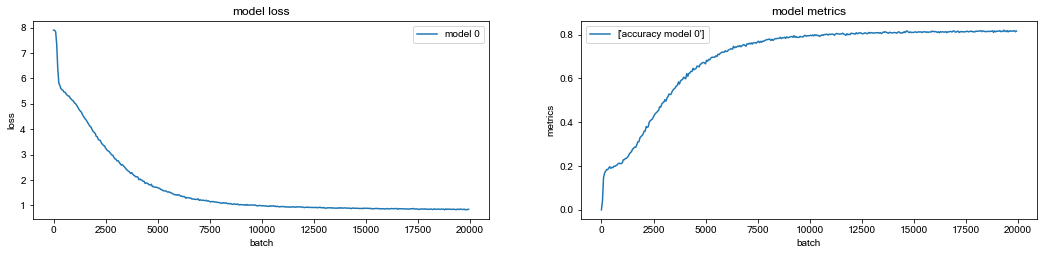

model 0      Step: 7s523ms  | Loss: 0.84179 | accuracy: 81.414%  | learning rate: 1.000e-03 | epoch: 8  ( 2000/2247 )

----- 第Epoch: 8後自動寫詞
----- temperature: 1.5
----- 根據以下詞彙發想:「透」
<start/>透明著塵埃<end/>
<start/>你無瑕的愛<end/>
<start/>你從雨中來<end/>
<start/>詩化了悲哀<end/>
<start/>我淋濕現在<end/>
<start/>載著你 也逗你笑<end/>
<start/>你繼續不敵我 致命的一擊<end/>
<start/>遠方的橫笛 

----- 根據以下詞彙發想:「我」
<start/>我在草地上喝著<end/>
<start/>麥芽糖的山坡<end/>
<start/>香濃的誘惑 你臉頰微熱<end/>
<start/>吐氣在我的耳朵<end/>
<start/>摘下麥芽糖熟透<end/>
<start/>我醒來還笑著<end/>
<start/>開心的 

----- 根據以下詞彙發想:「雜」
<start/>雜訊太多訊號  就連風吹都要干擾  可是你不想<end/>
<start/>一直走在黑暗地下道  想吹風想自由想要一起手牽手<end/>
<start/>去看海繞世界流浪<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>別管那是非只要我們感覺對<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>別管那是非只要我們感覺對<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>別管那是非只要我們感覺對<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>別管那是非只要我們感覺對<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>別管那是非只要我們感覺對<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>別管那是非只要我們感覺對<end/>
<start/>我害怕你心碎沒人幫你擦眼淚<end/>
<start/>

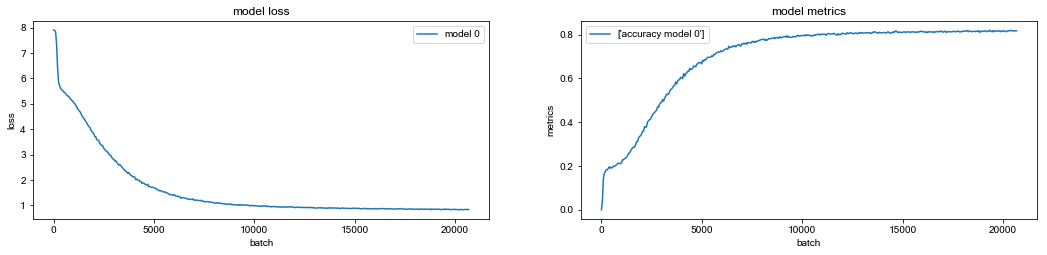

model 0      Step: 9s453ms  | Loss: 0.84450 | accuracy: 81.398%  | learning rate: 1.000e-03 | epoch: 9  ( 500/2247 )
model 0      Step: 6s439ms  | Loss: 0.83295 | accuracy: 81.758%  | learning rate: 1.000e-03 | epoch: 9  ( 550/2247 )
model 0      Step: 8s220ms  | Loss: 0.84343 | accuracy: 81.523%  | learning rate: 1.000e-03 | epoch: 9  ( 600/2247 )
model 0      Step: 7s340ms  | Loss: 0.83941 | accuracy: 81.578%  | learning rate: 1.000e-03 | epoch: 9  ( 650/2247 )
model 0      Step: 8s27ms   | Loss: 0.83566 | accuracy: 81.594%  | learning rate: 1.000e-03 | epoch: 9  ( 700/2247 )
model 0      Step: 6s90ms   | Loss: 0.83883 | accuracy: 81.703%  | learning rate: 1.000e-03 | epoch: 9  ( 750/2247 )

----- 第Epoch: 9後自動寫詞
----- temperature: 1.5
----- 根據以下詞彙發想:「讓」
<start/>讓我連恨都難以下筆<end/>
<start/>將真心抽離寫成日記 像是一場默劇<end/>
<start/>你的完美主義 太徹底<end/>
<start/>讓我連恨都難以下筆<end/>
<start/>將真心抽離寫成日記 

----- 根據以下詞彙發想:「放」
<start/>放抹記 剩最後一口氣<end/>
<start/>放抹記<end/>
<start/>龍是 笑容酸甘呀甜<end/>
<start/>龍是 笑容酸甘呀甜<end/>


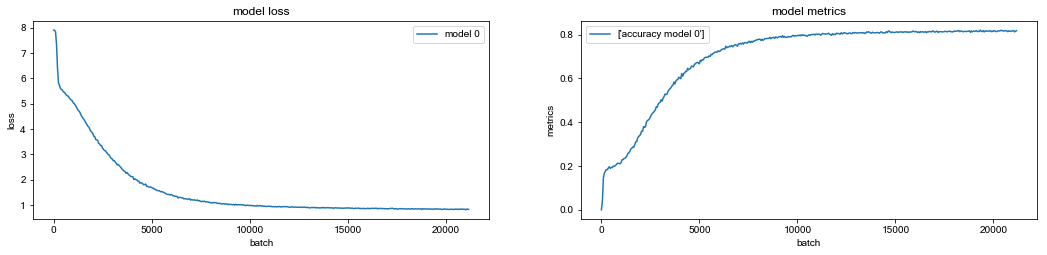

model 0      Step: 8s540ms  | Loss: 0.82540 | accuracy: 81.945%  | learning rate: 1.000e-03 | epoch: 9  ( 1000/2247 )
model 0      Step: 6s34ms   | Loss: 0.82805 | accuracy: 81.953%  | learning rate: 1.000e-03 | epoch: 9  ( 1050/2247 )
model 0      Step: 7s458ms  | Loss: 0.83841 | accuracy: 81.539%  | learning rate: 1.000e-03 | epoch: 9  ( 1100/2247 )
model 0      Step: 5s988ms  | Loss: 0.81997 | accuracy: 82.148%  | learning rate: 1.000e-03 | epoch: 9  ( 1150/2247 )
model 0      Step: 7s56ms   | Loss: 0.82588 | accuracy: 81.945%  | learning rate: 1.000e-03 | epoch: 9  ( 1200/2247 )
model 0      Step: 5s993ms  | Loss: 0.84059 | accuracy: 81.609%  | learning rate: 1.000e-03 | epoch: 9  ( 1250/2247 )

----- 第Epoch: 9後自動寫詞
----- temperature: 1.5
----- 根據以下詞彙發想:「等」
<start/>等花藝　球有球ki<end/>
<start/>等俠義　文物得急<end/>
<start/>等庖丁　得捂得裡<end/>
<start/>等消息　藍龍沒休於<end/>
<start/>黑板上的日期<end/>
<start/>倒數找你<end/>
<start/>慢慢清晰 

----- 根據以下詞彙發想:「我」
<start/>我們愉快的夢遊<end/>
<start/>我在草地上喝著<end/>
<start/>麥芽糖釀的酒<e

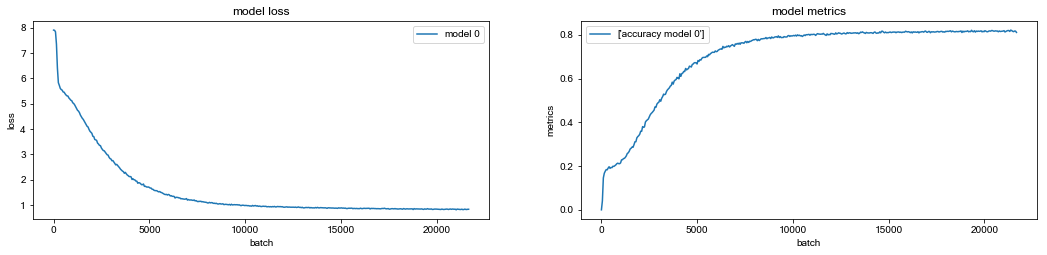

model 0      Step: 8s833ms  | Loss: 0.83686 | accuracy: 81.516%  | learning rate: 1.000e-03 | epoch: 9  ( 1500/2247 )
model 0      Step: 6s292ms  | Loss: 0.84943 | accuracy: 81.570%  | learning rate: 1.000e-03 | epoch: 9  ( 1550/2247 )
model 0      Step: 7s810ms  | Loss: 0.83621 | accuracy: 81.672%  | learning rate: 1.000e-03 | epoch: 9  ( 1600/2247 )
model 0      Step: 6s232ms  | Loss: 0.82915 | accuracy: 81.734%  | learning rate: 1.000e-03 | epoch: 9  ( 1650/2247 )
model 0      Step: 7s718ms  | Loss: 0.82205 | accuracy: 82.156%  | learning rate: 1.000e-03 | epoch: 9  ( 1700/2247 )
model 0      Step: 6s207ms  | Loss: 0.83040 | accuracy: 81.750%  | learning rate: 1.000e-03 | epoch: 9  ( 1750/2247 )

----- 第Epoch: 9後自動寫詞
----- temperature: 1.5
----- 根據以下詞彙發想:「你」
<start/>你的崩潰在窗外零碎<end/>
<start/>我一路向北<end/>
<start/>離開有你的季節<end/>
<start/>你說你好累<end/>
<start/>已無法再愛上誰<end/>
<start/>風在山路吹<end/>
<start/>過往的畫面<end/>
<start/>全都是我不對<end/>
<start/>細數慚愧 

----- 根據以下詞彙發想:「你」
<start/>你我的過去 被順時針地忘記<end

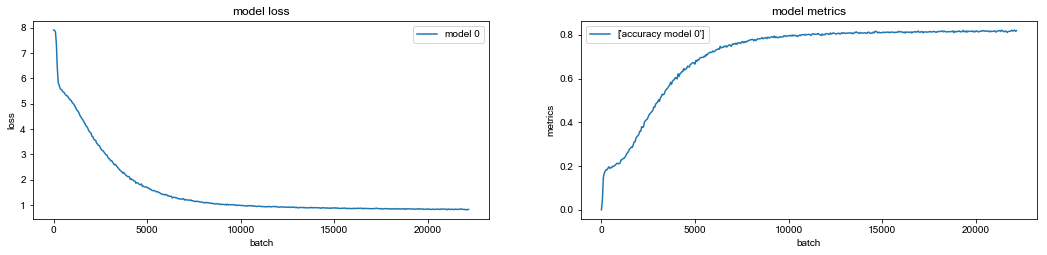

model 0      Step: 8s690ms  | Loss: 0.83645 | accuracy: 81.617%  | learning rate: 1.000e-03 | epoch: 9  ( 2000/2247 )
model 0      Step: 6s236ms  | Loss: 0.82513 | accuracy: 82.125%  | learning rate: 1.000e-03 | epoch: 9  ( 2050/2247 )
model 0      Step: 7s530ms  | Loss: 0.82916 | accuracy: 81.758%  | learning rate: 1.000e-03 | epoch: 9  ( 2100/2247 )
model 0      Step: 6s422ms  | Loss: 0.82024 | accuracy: 81.641%  | learning rate: 1.000e-03 | epoch: 9  ( 2150/2247 )
model 0      Step: 7s356ms  | Loss: 0.81959 | accuracy: 81.445%  | learning rate: 1.000e-03 | epoch: 9  ( 2200/2247 )


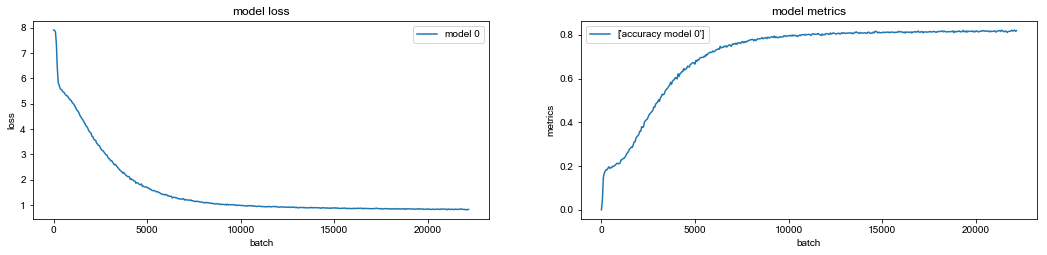

In [9]:

lstm_jay\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(SequenceCrossEntropyLoss)\
    .with_metric(SequenceAccuracy,name='accuracy')\
    .with_grad_clipping(3)\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/{0}.pth.tar'.format(item))\
    .trigger_when('on_batch_end', action=write_something) \
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=2,cooldown=1,threshold=5e-4,warmup=0) \
    .with_automatic_mixed_precision_training()


plan=TrainingPlan()\
    .add_training_item(lstm_jay)\
    .with_data_loader(data_provider)\
    .repeat_epochs(10)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(50,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=500,unit='batch',imshow=True)\
    .print_gradients_scheduling(500)\
    .save_model_scheduling(100,unit='batch')

plan.start_now()

## 為你寫唐詩

既然是「為你寫詩」，當然除了寫歌詞之外，還要挑戰更難一點的任務，那就是寫真正的詩，而且是唐詩的風格。我這邊分別準備了五言絕句(poets54.txt，共4065首)、七言絕句(poets74.txt，共10730首)、五言律詩(poets58.txt，共14409首)、七言律詩(poets78.txt，共8180首)這四種語料，我們就來挑戰語料量最豐富的五言律詩。

In [10]:
item='poets58' 

data_provider,original_corpus=load_text(item+'.txt',unit='char',is_onehot=False,sequence_length=50,sequence_start_at='section_start',return_corpus=True)
t1,t2=data_provider.next()

for k in range(8):
    print(''.join([data_provider.index2text(i) for i in t1[k]]))
    print(''.join([data_provider.index2text(i) for i in t2[k]]))
    print('')
print(data_provider.signature)

total distinct chars: 5745
total distinct chars: 5745
<start/>東城南陌塵 紫幰與朱輪 盡說無多事 能閑有幾人 唯教推甲子 不信守庚申 誰見衡門裏 終朝自在貧<end/><pad/>
東城南陌塵 紫幰與朱輪 盡說無多事 能閑有幾人 唯教推甲子 不信守庚申 誰見衡門裏 終朝自在貧<end/><pad/><pad/>

<start/>杉竹映溪關 修修共歲寒 幽人眠日晏 花雨落春殘 道妙言何強 詩玄論甚難 閑居有親賦 搔首憶潘安<end/><pad/>
杉竹映溪關 修修共歲寒 幽人眠日晏 花雨落春殘 道妙言何強 詩玄論甚難 閑居有親賦 搔首憶潘安<end/><pad/><pad/>

<start/>五言五百篇 七字七十九 三字二十一 都來六百首 一例書巖石 自誇云好手 若能會我詩 真是如來母<end/><pad/>
五言五百篇 七字七十九 三字二十一 都來六百首 一例書巖石 自誇云好手 若能會我詩 真是如來母<end/><pad/><pad/>

<start/>幽室獨焚香 清晨下未央 山開登竹閣 僧到出茶牀 收拾新琴譜 封題舊藥方 逍遙無別事 不似在班行<end/><pad/>
幽室獨焚香 清晨下未央 山開登竹閣 僧到出茶牀 收拾新琴譜 封題舊藥方 逍遙無別事 不似在班行<end/><pad/><pad/>

<start/>春草晚來色 東門愁送君 盛才仍下位 明代負奇文 且樂神仙道 終隨鴛鷺羣 梅生寄黃綬 不日在青雲<end/><pad/>
春草晚來色 東門愁送君 盛才仍下位 明代負奇文 且樂神仙道 終隨鴛鷺羣 梅生寄黃綬 不日在青雲<end/><pad/><pad/>

<start/>昨日遊峰頂 下窺千尺崖 臨危一株樹 風擺兩枝開 雨漂即零落 日曬作塵埃 嗟見此茂秀 今爲一聚灰<end/><pad/>
昨日遊峰頂 下窺千尺崖 臨危一株樹 風擺兩枝開 雨漂即零落 日曬作塵埃 嗟見此茂秀 今爲一聚灰<end/><pad/><pad/>

<start/>姹女住瑤臺 仙花滿地開 金苗從此出 玉蘂自天來 鳳舞長生曲 鸞歌續命杯 有人明此道 海變已千回<end/><pad/>
姹女住瑤臺 仙花滿地開 金苗從此出 玉蘂自天來 鳳舞長生曲 鸞歌續命杯 有人明此道 海變已千回<end/><pad/><pad/>

<

五言律詩由於有上萬首，使用的中文字數當然也不少，高達了5745個，再加上古文用字精簡，背後還有格律平仄對仗等隱規則，當然我們這次沒有提供文字以外的資訊給機器學，所以要光從文字本身找到隱含的語義其實難度頗高。但是只要是剛才介紹的模型結構以及log_softmax的收斂技巧應該只要稍微調整嵌入層特徵大小，以及增加隱藏層尺寸應該是可以勝任這個挑戰，但是未來專案中或是遇到搞不定的模型，這個時候該如何解決這個問題呢。

在訓練多分類的rnn模型時，我會有以下幾個建議：

**1. 不要盲目地增加lstm層數，除非你很有空閒時間很多可以看他慢慢收斂，一般建議兩層即可，再多層只是變得更難訓練。**

**2. 不要以為改用雙向lstm效果會變好，因為這是預測下一個字，所以建模時事知道全句所以看似效果很好，但是實際推論時則是很糟。**

**3. 在嵌入層、lstm隱藏層一直到最後全連接層的輸出，建議尺寸的設定依照金字塔型(pyrimid)的方式設定也就是這三層依照接近等比級數的方式設定是最好的，應該是前面小，後面逐步放大，所以我這邊是依序設為256,1024, 5869以接近4倍遞增的形式來設定。** 

**4. 除了在網絡結構上找問題，更應該先檢視語料有無問題，是否有編碼不一致造成的無法顯示字元、罕見字，全形字或者是unicode中日韓區域中非中文使用漢字，排除清理這些會讓模型訓練的更有效率**      


In [15]:
h_size=1024
num_chars=len(data_provider.vocabs)

lstm2=Sequential(
    Embedding(embedding_dim=256,num_embeddings=num_chars,sparse=False),
    BatchNorm(in_sequence=True,affine=True),
    LSTM(hidden_size=h_size,num_layers=2,stateful=False,batch_first=True,dropout_rate=0.2),
    Reshape((h_size)),
    Dense(num_chars,use_bias=False,activation=None),
    SoftMax()
    )

lstm_poet2=Model(inputs=t1,output=lstm2)

接著就來執行一下，看看機器讀完上萬首唐詩會出現甚麼樣的作品。

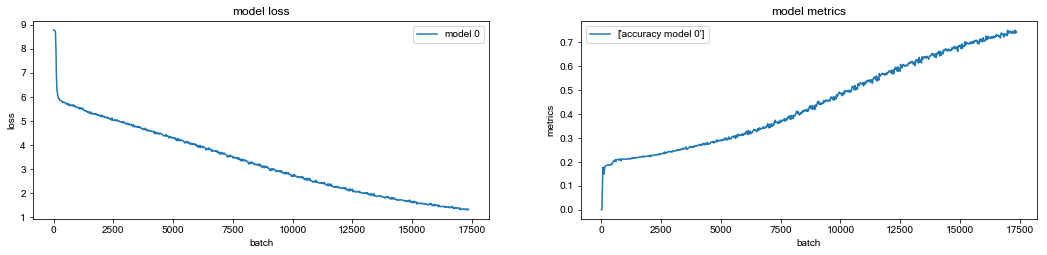

model 0      Step: 9s38ms   | Loss: 1.29846 | accuracy: 75.275%  | learning rate: 1.000e-03 | epoch: 19  ( 400/894 )
model 0           first_layer gradients: 8.496e+01| last_layer gradients: 1.525e+02
model 0      Step: 11s924ms | Loss: 1.30722 | accuracy: 74.694%  | learning rate: 1.000e-03 | epoch: 19  ( 420/894 )
model 0      Step: 7s339ms  | Loss: 1.29481 | accuracy: 75.069%  | learning rate: 1.000e-03 | epoch: 19  ( 440/894 )
model 0      Step: 7s883ms  | Loss: 1.31933 | accuracy: 74.700%  | learning rate: 1.000e-03 | epoch: 19  ( 460/894 )
model 0      Step: 11s560ms | Loss: 1.29101 | accuracy: 74.994%  | learning rate: 1.000e-03 | epoch: 19  ( 480/894 )


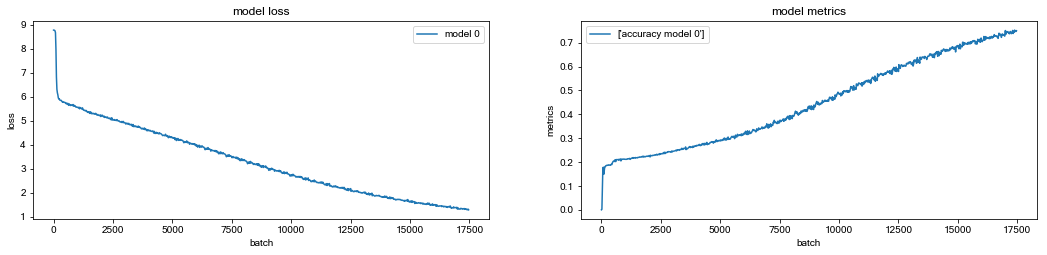

model 0      Step: 8s933ms  | Loss: 1.29267 | accuracy: 75.737%  | learning rate: 1.000e-03 | epoch: 19  ( 500/894 )

----- 第Epoch: 19後自動寫詞
----- temperature: 1.5
----- 根據以下詞彙發想:「老」
<start/>老恥妻孥笑 貧歸白社師 風塵非自醉 林藪許誰歌 每許清江便 言同一味書 終須修朮史 豈令臥風清<end/>
<end/>


----- 根據以下詞彙發想:「正」
<start/>正是花時節 情親別有親 漢家親故里 郢曲泛新安 楚驛雲霄出 秦吳水遶連 王城莫待月 知爾欲攀刀<end/>
<end/>


----- 根據以下詞彙發想:「分」
<start/>分手十萬里 不道別離差 況是初分地 今來已別君 金簾寬暗雪 金殿已生雲 好作龍泉上 無由也是閑<end/>
<end/>


model 0           first_layer gradients: 7.964e+01| last_layer gradients: 1.495e+02
model 0      Step: 13s594ms | Loss: 1.30780 | accuracy: 75.250%  | learning rate: 1.000e-03 | epoch: 19  ( 520/894 )
model 0      Step: 7s135ms  | Loss: 1.31404 | accuracy: 74.456%  | learning rate: 1.000e-03 | epoch: 19  ( 540/894 )
model 0      Step: 7s539ms  | Loss: 1.32195 | accuracy: 75.050%  | learning rate: 1.000e-03 | epoch: 19  ( 560/894 )
model 0      Step: 11s507ms | Loss: 1.29917 | accuracy: 74.675%  | learning rate: 1.000e-03 | epoch: 19  ( 580/894 )


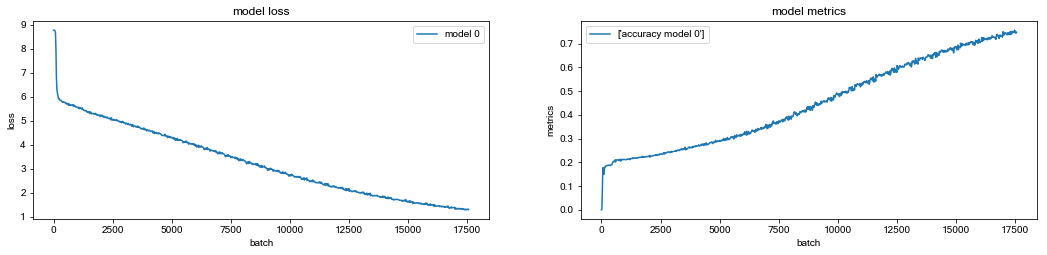

model 0      Step: 8s619ms  | Loss: 1.32407 | accuracy: 74.387%  | learning rate: 1.000e-03 | epoch: 19  ( 600/894 )
model 0           first_layer gradients: 8.907e+01| last_layer gradients: 1.601e+02
model 0      Step: 11s350ms | Loss: 1.29710 | accuracy: 74.350%  | learning rate: 1.000e-03 | epoch: 19  ( 620/894 )
model 0      Step: 7s453ms  | Loss: 1.27076 | accuracy: 75.906%  | learning rate: 1.000e-03 | epoch: 19  ( 640/894 )
model 0      Step: 7s660ms  | Loss: 1.28042 | accuracy: 75.544%  | learning rate: 1.000e-03 | epoch: 19  ( 660/894 )
model 0      Step: 11s704ms | Loss: 1.27565 | accuracy: 75.644%  | learning rate: 1.000e-03 | epoch: 19  ( 680/894 )


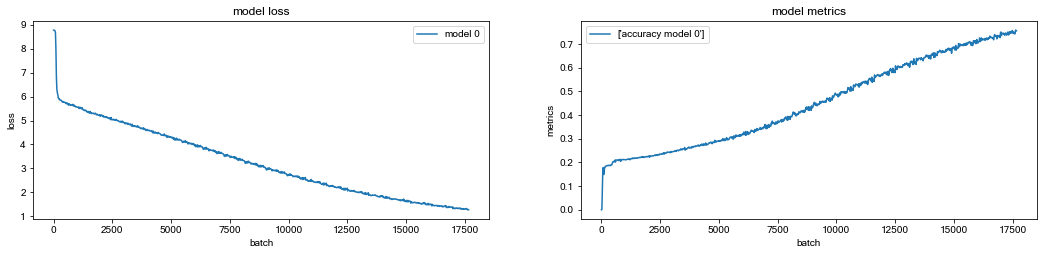

model 0      Step: 9s29ms   | Loss: 1.28658 | accuracy: 74.719%  | learning rate: 1.000e-03 | epoch: 19  ( 700/894 )
model 0           first_layer gradients: 8.724e+01| last_layer gradients: 1.528e+02
model 0      Step: 10s690ms | Loss: 1.26341 | accuracy: 75.769%  | learning rate: 1.000e-03 | epoch: 19  ( 720/894 )
model 0      Step: 7s974ms  | Loss: 1.30554 | accuracy: 74.706%  | learning rate: 1.000e-03 | epoch: 19  ( 740/894 )
model 0      Step: 7s891ms  | Loss: 1.27492 | accuracy: 75.506%  | learning rate: 1.000e-03 | epoch: 19  ( 760/894 )
model 0      Step: 11s238ms | Loss: 1.26926 | accuracy: 75.731%  | learning rate: 1.000e-03 | epoch: 19  ( 780/894 )


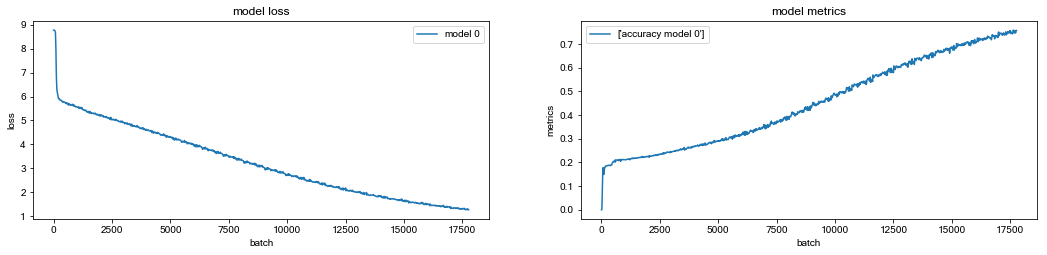

model 0      Step: 9s546ms  | Loss: 1.30809 | accuracy: 74.381%  | learning rate: 1.000e-03 | epoch: 19  ( 800/894 )
model 0           first_layer gradients: 8.055e+01| last_layer gradients: 1.471e+02
model 0      Step: 12s208ms | Loss: 1.27213 | accuracy: 75.387%  | learning rate: 1.000e-03 | epoch: 19  ( 820/894 )
model 0      Step: 7s198ms  | Loss: 1.27367 | accuracy: 75.637%  | learning rate: 1.000e-03 | epoch: 19  ( 840/894 )
model 0      Step: 7s528ms  | Loss: 1.28961 | accuracy: 74.775%  | learning rate: 1.000e-03 | epoch: 19  ( 860/894 )
model 0      Step: 13s909ms | Loss: 1.27200 | accuracy: 75.256%  | learning rate: 1.000e-03 | epoch: 19  ( 880/894 )


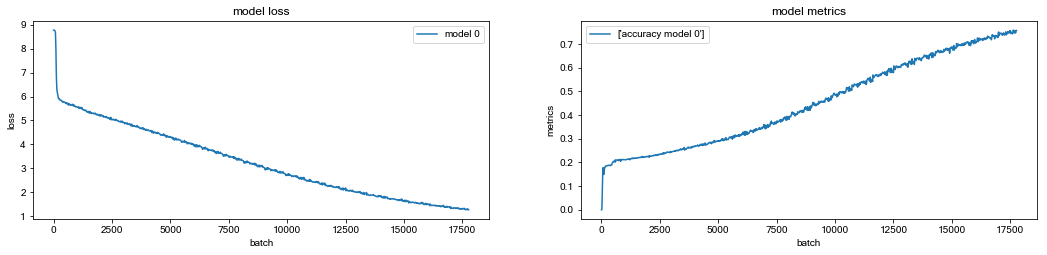

In [16]:

lstm_poet2\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(SequenceCrossEntropyLoss)\
    .with_metric(SequenceAccuracy,name='accuracy')\
    .with_grad_clipping(3)\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm') \
    .with_model_save_path('Models/{0}.pth.tar'.format(item))\
    .trigger_when('on_batch_end', action=write_something) \
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0) \
    .with_automatic_mixed_precision_training()



plan=TrainingPlan()\
    .add_training_item(lstm_poet2)\
    .with_data_loader(data_provider)\
    .repeat_epochs(20)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .print_gradients_scheduling(100)\
    .save_model_scheduling(50,unit='batch')

plan.start_now()



In [21]:
#寫藏頭詩
def get_hidden_poetry(heading,temperature = 1.8):

    model =load('Models/{0}.pth'.format(item))
    # 模型千萬記得要轉換成eval模式
    model.eval()
    for  module in model.modules():
        if isinstance(module, LSTM):
            module.stateful=True
    #清除模型狀態
    for module in model.modules():
        if isinstance(module, LSTM):
            module.clear_state()
    model.eval()
    

    print()
    print('----- 以「{0}」寫藏頭詩'.format(heading))

    print('----- temperature:', temperature)

    
    text_generated = []
    heading_idx=0
    start_string = heading[heading_idx]
    text_generated.append('<start/>')
    text_generated.append(heading[heading_idx])
    
    heading_idx+=1


    seq = [data_provider.text2index(s) for s in start_string]
    seq.insert(0, 0)
    # seq.append(1)
    input_eval = to_tensor([seq]).long().detach()
    if ndim(input_eval)<2:
        input_eval=input_eval.expand_dims(0)


    is_finished = False
    num_generate = 0
    row_length=0

    sys.stdout.write(start_string)

    while not is_finished:
        try:

            predictions = model(input_eval)[-1]
            predicted_idx=argsort(predictions)[:10]
            predicted_probs = predictions[predicted_idx]
            predicted_id = predicted_idx[multinomial(predicted_probs, num_samples=1)].item()
            #predicted_id = argmax(predictions).item()
            
            input_eval = to_tensor([[predicted_id]]).long().detach()
            

            if text_generated[-1]==' ' and heading_idx<len(heading):
                text_generated.append(heading[heading_idx])
                #更新字頭 覆寫成為下次的輸入
                input_eval = to_tensor([[data_provider.text2index(heading[heading_idx])]]).long().detach()
                heading_idx+=1
            else:
                text_generated.append(data_provider.index2text(predicted_id))
            
            
            if ndim(input_eval) < 2:
                input_eval = input_eval.expand_dims(0)
                
            
            if len(text_generated)>10 and len(list(set(text_generated[-5:])))==1:
                is_finished = True

                break
            if text_generated[-2] == '<pad/>' and text_generated[-1] == '<pad/>':
                sys.stdout.write('\n\n')
                sys.stdout.flush()
                is_finished = True
            if text_generated[-1] == '<end/>' :
                sys.stdout.write('\n')
                sys.stdout.flush()
            elif text_generated[-1] not in ['</start>','<pad/>', '<unknown/>']:
                sys.stdout.write(text_generated[-1])
                row_length += 1
                if row_length >= 47 and text_generated[-1] in ['，', '。',' ', '<end/>']:
                    sys.stdout.write('\n')
                    is_finished=True
                sys.stdout.flush()
            num_generate += 1
        except Exception as e:
            print(e)
    model.train()
    print()
    



In [22]:
get_hidden_poetry('白日依山黃河入海')


----- 以「白日依山黃河入海」寫藏頭詩
----- temperature: 1.8
白馬向邊使 日輪堪報愁 依然地平別 山聽獨雞歸 黃葉落前山 河羊穿上樓 入吟猶未足 海嶠有風濤





In [23]:
get_hidden_poetry('沉魚落雁閉月羞花',1.2)


----- 以「沉魚落雁閉月羞花」寫藏頭詩
----- temperature: 1.2
沉痾旌已盡 魚駕日東來 落葉平蕪去 雁門開到門 閉門山果熟 月影竹房深 羞是相如懶 花間亦獨遊



